In [48]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import sys
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
import statsmodels.formula.api as smf
from statsmodels.stats.mediation import Mediation
from pyprocessmacro import Process


from mri_data import file_manager as fm

In [49]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/edss_regressions")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")

# df['thalamus_sq'] = (df['thalamus']/df['thalamus'].mean())**2
df['thalamus_sq'] = np.square(df['thalamus'])
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')

df = helpers.get_mri_edss_delta(df)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [50]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
# df_thomas['THALAMUS_1_sq'] = (df_thomas['THALAMUS_1']/df_thomas["THALAMUS_1"].mean())**2
df_thomas['THALAMUS_1_sq'] = np.square(df_thomas['THALAMUS_1'])

df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['intralaminar'] = df['CM_11'] 
    df2['medial'] = df['MD_Pf_12']
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

df_thomas2 = combine_nuclei(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

## Functions

In [51]:
def plot_moderation(model_data, y_name, x_name, w_name, covariates,
                    xlab_name=None, ylab_name=None, wlab_name=None):
    if xlab_name is None:
        xlab_name = x_name
    if ylab_name is None:
        ylab_name = y_name
    if wlab_name is None:
        wlab_name = w_name

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""

    xcent_name = f"{x_name}_cent"
    wcent_name = f"{y_name}_cent"
    model_data[xcent_name] = model_data[x_name] - model_data[x_name].mean()
    model_data[wcent_name] = model_data[w_name] - model_data[w_name].mean()

    formula = f"{y_name} ~ {wcent_name}*{xcent_name} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()

    x_rng, y_lvls = helpers.moderation_y(model_data, res, xcent_name, wcent_name)
    # fix x_rng since the moderation_y took the centered version
    x_rng = np.linspace(model_data[x_name].min(), model_data[x_name].max(), 100)
    # x_rng = np.linspace(0, 20, 100)


    cmap = model_data[w_name] / model_data[w_name].max()
    # helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
    plt.scatter(model_data[x_name], model_data[y_name], s=8, color=viridis(cmap))

    # m-sd line
    plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
    # plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

    plt.plot(x_rng, y_lvls[1][0], label=f"m ({wlab_name})", linestyle="-", color="black")
    plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.2)

    plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
    # plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

    plt.legend()
    plt.xlabel(xlab_name)
    plt.ylabel(ylab_name)
    plt.show()




## Assumption Checks

(14.526102083270017,
 0.005792118604547826,
 3.7078127845128024,
 0.005533295524941609)

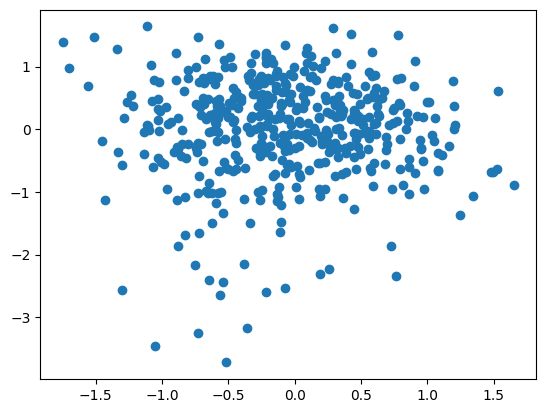

In [7]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]
# model_data = model_data[model_data['t2lv'] < 4]

formula = "thalamus ~ choroid_volume + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()

pred = res.predict(model_data)
plt.scatter(res.fittedvalues, res.resid)
het_breuschpagan(res.resid, res.model.exog)

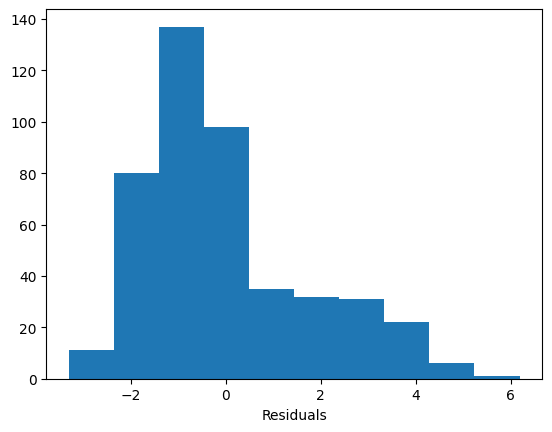

ShapiroResult(statistic=0.9191940539121408, pvalue=7.306533224496594e-15)
0.9467798000853934
0.25000782264235744


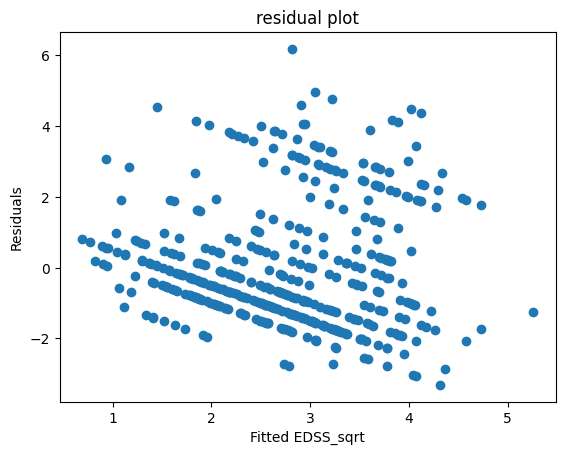

Text(0.5, 1.0, 'QQ Plot for Residuals')

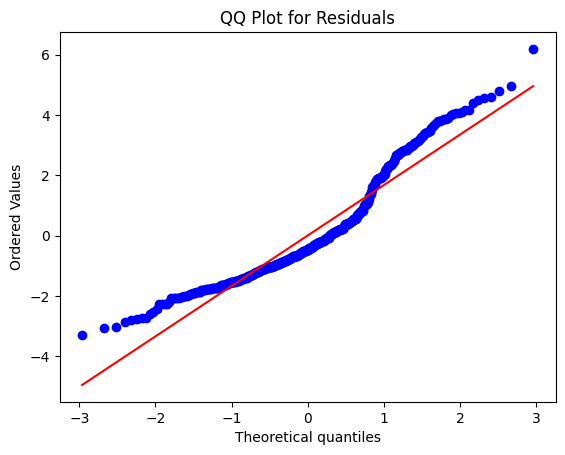

In [53]:
model_data = df_ms.join([df_thomas])
formula = "EDSS ~ age + Female + scale(tiv)"
res = sm.OLS.from_formula(formula, data=model_data).fit()

check = res.resid
plt.hist(check)
plt.xlabel("Residuals")
plt.show()
print(stats.shapiro(check))
print(stats.skew(check))
print(stats.kurtosis(check))

plt.scatter(res.fittedvalues, check)
plt.xlabel("Fitted EDSS_sqrt")
plt.ylabel("Residuals")
plt.title("residual plot")
plt.show()
stats.probplot(check, dist="norm", plot=plt)
plt.title("QQ Plot for Residuals")

In [58]:
sum(model_data['EDSS'] == 0)

11

## Moderation 

thalamus ~ t2lv moderated by choroid_volume

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     96.39
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           3.49e-78
Time:                        13:16:14   Log-Likelihood:                -477.45
No. Observations:                 468   AIC:                             968.9
Df Residuals:                     461   BIC:                             997.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

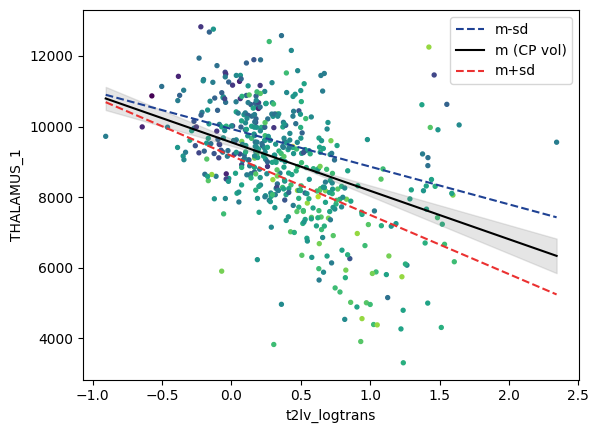

In [9]:
model_data = df_ms_z.join([df_thomas_z])
formula = "THALAMUS_1 ~ choroid_volume*t2lv_logtrans + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

plot_data = df_ms.join([df_thomas])
plot_moderation(plot_data, "THALAMUS_1", "t2lv_logtrans", "choroid_volume", "age + Female + tiv", wlab_name="CP vol")

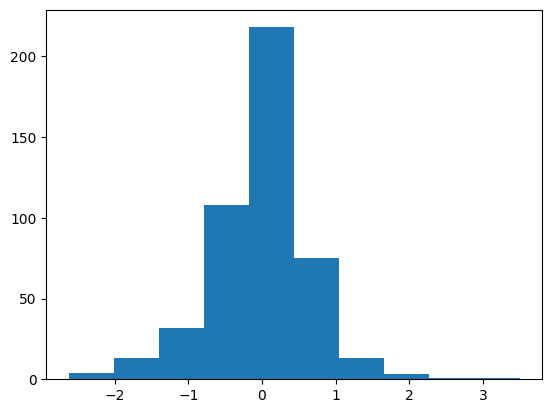

ShapiroResult(statistic=0.9603539753814555, pvalue=6.560643643156432e-10)
-0.1927982257034771
5.731008703022117


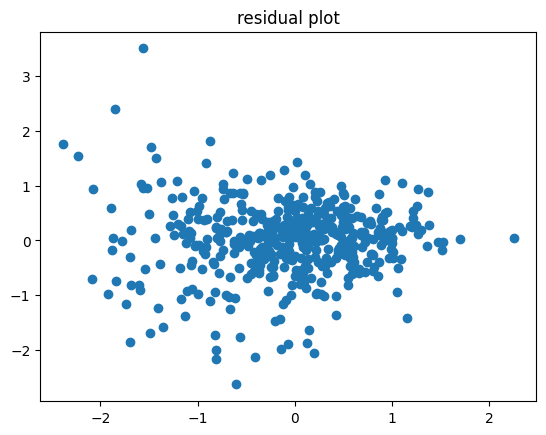

((array([-2.97186429e+00, -2.68816597e+00, -2.52851125e+00, -2.41523836e+00,
         -2.32644001e+00, -2.25290304e+00, -2.18984559e+00, -2.13445430e+00,
         -2.08492857e+00, -2.04004385e+00, -1.99892811e+00, -1.96093756e+00,
         -1.92558286e+00, -1.89248302e+00, -1.86133539e+00, -1.83189543e+00,
         -1.80396256e+00, -1.77737020e+00, -1.75197839e+00, -1.72766837e+00,
         -1.70433847e+00, -1.68190096e+00, -1.66027959e+00, -1.63940763e+00,
         -1.61922636e+00, -1.59968383e+00, -1.58073381e+00, -1.56233501e+00,
         -1.54445038e+00, -1.52704655e+00, -1.51009333e+00, -1.49356335e+00,
         -1.47743168e+00, -1.46167558e+00, -1.44627421e+00, -1.43120846e+00,
         -1.41646073e+00, -1.40201480e+00, -1.38785566e+00, -1.37396942e+00,
         -1.36034318e+00, -1.34696494e+00, -1.33382353e+00, -1.32090851e+00,
         -1.30821014e+00, -1.29571927e+00, -1.28342736e+00, -1.27132636e+00,
         -1.25940872e+00, -1.24766732e+00, -1.23609544e+00, -1.22468676e+00,

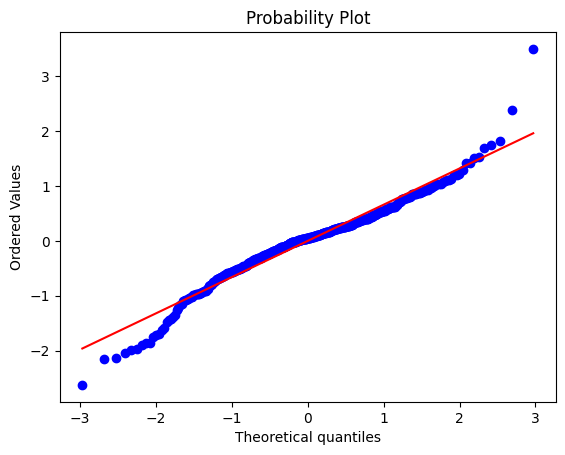

In [11]:
check = res.resid
# check = check[check < 3]
# check = check[check > -2]
plt.hist(check)
plt.show()
print(stats.shapiro(check))
print(stats.skew(check))
print(stats.kurtosis(check, fisher=False))

plt.scatter(res.fittedvalues, check)
plt.title("residual plot")
plt.show()
stats.probplot(check, dist="norm", plot=plt)

ShapiroResult(statistic=0.9952982257428726, pvalue=0.07867740797828145)

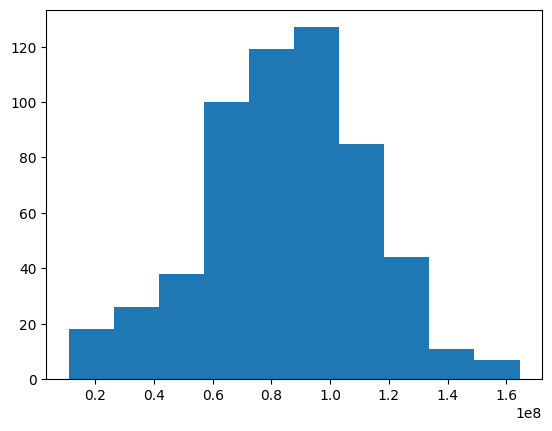

In [ ]:
0.9772261287588467, pvalue=1.083192518471833e-06
plt.hist(df_thomas['THALAMUS_1_sq'])
stats.shapiro(df_thomas['THALAMUS_1_sq'])

cortical_thickness ~ t2lv moderated by choroid_volume

                            OLS Regression Results                            
Dep. Variable:     cortical_thickness   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     59.74
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           1.35e-54
Time:                        16:16:33   Log-Likelihood:                -529.45
No. Observations:                 468   AIC:                             1073.
Df Residuals:                     461   BIC:                             1102.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

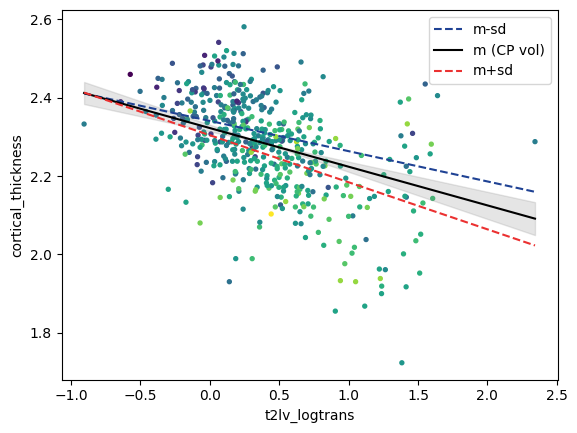

In [50]:
formula = "cortical_thickness ~ t2lv_logtrans*choroid_volume + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())
plot_moderation(plot_data, "cortical_thickness", "t2lv_logtrans", "choroid_volume", "age + Female + tiv", wlab_name="CP vol")

## Mediation

### EDSS

Thalamus may be mediating effect of t2lv on EDSS

In [57]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

formula = "EDSS_sqrt ~ t2lv_logtrans + THALAMUS_1 + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     34.72
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           3.87e-30
Time:                        16:22:14   Log-Likelihood:                -582.22
No. Observations:                 468   AIC:                             1176.
Df Residuals:                     462   BIC:                             1201.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0313      0.039     -0.796

Cortical thickness may be mediating effect of t2lv on EDSS

In [58]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

formula = "EDSS_sqrt ~ t2lv_logtrans + cortical_thickness + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     31.47
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           1.37e-27
Time:                        16:22:48   Log-Likelihood:                -588.28
No. Observations:                 468   AIC:                             1189.
Df Residuals:                     462   BIC:                             1213.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0076      0

The effect of cortical thickness on EDSS disappears when adding thalamus to model. Could thalamus also mediate the effect of cortical thickness on EDSS? Could cortical thinning lead to wallerian degeneraton of the thalamus? If the thalamus routes all signals between cortex and periphery, then perhaps you would see little direct effect of cortical thinning

In [6]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

formula = "EDSS_sqrt ~ THALAMUS_1 + cortical_thickness + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     35.16
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           1.77e-30
Time:                        15:38:01   Log-Likelihood:                -581.42
No. Observations:                 468   AIC:                             1175.
Df Residuals:                     462   BIC:                             1200.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0277      0

In [9]:
model_data = df_ms_z.join([df_thomas_z])

p2 = Process(data=model_data, model=4, x="t2lv", y="THALAMUS_1",
            m=["choroid_volume"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = t2lv
    y = THALAMUS_1
    m1 = choroid_volume
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5101   0.5037 0.5040 96.1922    5  462   0.0000

Coefficients

                 coeff     se       t      p    LLCI    ULCI
Cons           -0.0866 0.0328 -2.6402 0.0086 -0.1510 -0.0223
t2lv           -0.2921 0.0348 -8.3882 0.0000 -0.3603 -0.2238
age            -0.1319 0.0363 -3.6315 0.0003 -0.2031 -0.0607
Female          0.0987 0.0400  2.46

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

## Process Macro

### EDSS

In [ ]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

# model_data.loc[model_data['EDSS_sqrt'].isna(), ] = 
p2 = Process(data=model_data, model=7, x="t2lv_logtrans", y="EDSS_sqrt", w="choroid_volume",
            m=["THALAMUS_1"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# original_stdout = sys.stdout
# with open(fig_path / "thalamus_model7_out.txt", 'w') as f:
#     sys.stdout = f
#     p2.summary()

# sys.stdout = original_stdout
p2.summary()

In [ ]:
p2 = Process(data=model_data, model=7, x="t2lv_logtrans", y="EDSS_sqrt", w="choroid_volume",
            m=["cortical_thickness"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# original_stdout = sys.stdout
# with open(fig_path / "cortical_thickness_model7_out.txt", 'w') as f:
#     sys.stdout = f
#     p2.summary()

# sys.stdout = original_stdout
p2.summary()

In [52]:
from pyprocessmacro import Process

model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=7, x="cortical_thickness", y="EDSS_sqrt", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = cortical_thickness
    y = EDSS_sqrt
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2788   0.2691 0.7452 34.5570    5  447   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0190 0.0408 -0.4655 0.6418 -0.0990  0.0610
cortical_thickness -0.0986 0.0565 -1.7451 0.0816 -0.2092  0.0121
age                 0.3153 0.0470  6.7080 0.0000  0.223

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [39]:
from pyprocessmacro import Process

model_data = df_z.copy()
model_data = model_data.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=4, x="choroid_volume", y="EDSS_sqrt",
            m=["THALAMUS_1", "cortical_thickness", "t2lv_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = EDSS_sqrt
    m1 = THALAMUS_1
    m2 = cortical_thickness
    m3 = t2lv_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2866   0.2738 0.7404 25.5418    7  445   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0214 0.0409 -0.5246 0.6001 -0.1015  0.0587
choroid_volume     -0.0726 0.0511 -1.4218 0.1558 -0.1727  0.0275
age                 0.3529 0.

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

---

In [34]:
model_data = df_z.copy()
model_data = model_data.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

outcome_model = sm.OLS.from_formula(
    "EDSS_sqrt ~ choroid_volume + cortical_thickness + age + tiv + Female", data=model_data
)
mediator_model = sm.OLS.from_formula(
    "cortical_thickness ~ choroid_volume + age + tiv + Female", data=model_data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "cortical_thickness"
).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.072454,0.032592,0.120427,0.000
ACME (treated),0.072454,0.032592,0.120427,0.000
ADE (control),-0.000346,-0.096817,0.100458,0.966
ADE (treated),-0.000346,-0.096817,0.100458,0.966
Total effect,0.072108,-0.024987,0.173202,0.152
Prop. mediated (control),0.900727,-5.956105,8.228081,0.152
Prop. mediated (treated),0.900727,-5.956105,8.228081,0.152
ACME (average),0.072454,0.032592,0.120427,0.000
ADE (average),-0.000346,-0.096817,0.100458,0.966
Prop. mediated (average),0.900727,-5.956105,8.228081,0.152


## On subnuclei

In [12]:
model_data = df_ms_z.join([df_thomas2_z])
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

p2 = Process(data=model_data, model=7, x="t2lv_logtrans", y="EDSS_sqrt", w="choroid_volume",
            m=["ventral"],
            controls=["age", "Female", "tiv", "THALAMUS_1"],
            controls_in="all")

p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = t2lv_logtrans
    y = EDSS_sqrt
    w = choroid_volume
    m1 = ventral
Statistical Controls:
 age, Female, tiv, THALAMUS_1



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2734   0.2624 0.7152 28.9153    6  461   0.0000

Coefficients

                coeff     se       t      p    LLCI    ULCI
Cons          -0.0306 0.0394 -0.7777 0.4372 -0.1079  0.0466
t2lv_logtrans  0.0146 0.0494  0.2956 0.7676 -0.0822  0.1114
age            0.3397 0.0431  7.8795 0.0000  0.2552  0.4242
Fema

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac